# Разработка A/B-тестирования и анализ результатов

Я работаю продуктовым аналитиком в компании, которая делает развлекательное приложение с «бесконечной» лентой - примерно как в сервисах с короткими видео. В приложении есть две модели монетизации: пользователи могут оформить ежемесячную подписку и смотреть контент без рекламы, либо же пользоваться бесплатно, но видеть рекламные вставки.

Недавно команда, которая отвечает за рекомендательную систему, разработала новый алгоритм. По их мнению, он должен подбирать для каждого пользователя более интересный и релевантный контент. Моя задача как аналитика - помочь рассчитать параметры A/B-теста, с помощью которого мы проверим эту гипотезу, а затем проанализировать его результаты.

## Описание данных

Для работы нам даны три таблицы:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-15 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных

In [37]:
# Импортируем библиотеку pandas.
import pandas as pd 

In [38]:
# Считываем и сохраняем в датафрейм `sessions_history` CSV-файл с историческими данными о сессиях пользователей `sessions_project_history.csv`.
sessions_history = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_history.csv')

In [39]:
# Выводим первые пять строк датафрейма `sessions_history`, чтобы убедиться, что данные считаны корректно.
display(sessions_history.head())

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


In [40]:
# Функция для автоматического осмотра данных
def lookup_datasets(dfs, filenames=None):
    """
    Выводит информацию о датасетах из списка

    Parameters:
        dfs (list of pd.DataFrame): Список датафреймов для обработки.
        filenames (list of str): Список названий файлов (имена для отображения).
    """
    if filenames is None:
        filenames = [f"df_{i + 1}" for i in range(len(dfs))]

    for df, df_name in zip(dfs, filenames):
        print('-'*10, ' '*5, df_name, ' '*5, '-'*10)

        # Пропущенные значения
        missing_data = df.isna().mean()
        missing_data_result = missing_data.apply(lambda x: f'{x:.2%}' if x > 0 else "")
        missing_data_name = "Пропущено" if missing_data.sum() > 0 else ""
        missing_data_result.name = missing_data_name

        # Типы данных
        dtypes_result = df.dtypes
        dtypes_result.name = "Тип данных колонки"
        fewest_nans_row = df.iloc[1:-1].isna().sum(axis=1).idxmin()

        values_type = df.loc[fewest_nans_row].map(type).T
        values_type.name = "Тип значения"

        # Проверка на полные дубликаты
        is_duplicate = df.duplicated(keep=False)
        duplicate_percentage = is_duplicate.mean()
        duplicate_info = pd.Series(
            ["Да" if val else "" for val in is_duplicate.iloc[[0, fewest_nans_row, -1]]],
            index=["Первая строка", "Типичная строка", "Последняя строка"],
            name="Дубликат"
        )

        # Объединяем результаты и примеры строк
        result = pd.concat([
            dtypes_result,                    # типы
            values_type,                     # типы значений
            missing_data_result,             # пропущенные значения
            df.iloc[0, :],                   # первая строка
            df.loc[fewest_nans_row].T,       # типичная строка
            df.iloc[-1, :],                  # последняя строка
        ], axis=1)

        result.columns = [
            "Тип данных", "Тип значения", missing_data_name or "Пропущено",
            "Первая строка", "Типичная строка", "Последняя строка"
        ]

        display(result)

        if duplicate_percentage > 0:
            print(f'Полных дубликатов: {duplicate_percentage:.2%}')
        else:
            print('Полных дубликатов не найдено.')

        print()

# Определяем словарь с датасетами
dfs = {
    "sessions_history": sessions_history
}

# Проводим автоматический осмотр данных
lookup_datasets(dfs.values(), dfs.keys())

----------       sessions_history       ----------


,Тип данных,Тип значения,Пропущено,Первая строка,Типичная строка,Последняя строка
user_id,object,<class 'str'>,,E302123B7000BFE4,2530F72E221829FB,5CC144801F7B0D1D
session_id,object,<class 'str'>,,F9AF61A0C2023832,85003A206CBDAC6F,8CC9E67AFF5D9CA8
session_date,object,<class 'str'>,,2025-08-15,2025-08-15,2025-09-17
session_start_ts,object,<class 'str'>,,2025-08-15 17:47:35,2025-08-15 16:42:14,2025-09-17 15:23:46
install_date,object,<class 'str'>,,2025-08-15,2025-08-15,2025-09-04
session_number,int64,<class 'numpy.int64'>,,1,1,3
registration_flag,int64,<class 'numpy.int64'>,,0,0,0
page_counter,int64,<class 'numpy.int64'>,,3,4,2
region,object,<class 'str'>,,CIS,MENA,MENA
device,object,<class 'str'>,,iPhone,Android,iPhone


Полных дубликатов не найдено.



#### 1.2. Знакомство с данными

Расчитаем для каждого уникального пользователя колличество уникальных сессий

In [41]:
# Групируем данные по пользователям и считаем количество уникальных сессий
sessions_count = sessions_history.groupby('user_id')['session_id'].nunique().reset_index()
# Переименовываем столбцы для удобства
sessions_count.columns = ['user_id', 'sessions_count']
# Сортируем данные по количеству сессий в порядке убывания
sessions_count = sessions_count.sort_values(by='sessions_count', ascending=False)
# Выводим первые пять строк полученного датафрейма
display(sessions_count.head())

,user_id,sessions_count
8948,10E0DEFC1ABDBBE0,10
55627,6A73CB5566BB494D,10
72346,8A60431A825D035B,9
109383,D11541BAC141FB94,9
47956,5BCFE7C4DCC148E9,9


In [42]:
# Выводим информацию о пользователи с наибольшим количеством сессий
sessions_history_max = sessions_history[sessions_history['user_id'] == sessions_count.iloc[0]['user_id']]
# Выводим данные на экран
display(sessions_history_max)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


#### 1.3. Анализ числа регистраций

Одна из ключевых метрик нашего продукта — это количество зарегистрированных пользователей. Чтобы лучше понять динамику, я решил взять исторические данные и посмотреть, как менялось число регистраций за всё время существования приложения.

In [43]:
# Агрегируем данные по дням и считаем количество уникальных пользователей
daily_users = sessions_history.groupby('session_date')['user_id'].nunique().reset_index()
# Переименовываем столбцы для удобства
daily_users.columns = ['session_date', 'unique_users']
# Сортируем данные по дате
daily_users = daily_users.sort_values(by='session_date')
# Агрегируем данные по дням и считаем количество зарегистрированных пользователей
daily_registered_users = sessions_history[sessions_history['registration_flag'] == 1].groupby('session_date')['user_id'].nunique().reset_index()
# Переименовываем столбцы для удобства
daily_registered_users.columns = ['session_date', 'registered_users']
# Сортируем данные по дате
daily_registered_users = daily_registered_users.sort_values(by='session_date')
# Объединяем данные по датам
daily_users = daily_users.merge(daily_registered_users, on='session_date', how='left')
# Считаем долю зарегистрированных пользователей от общего числа уникальных пользователей
daily_users['registered_users_share'] = daily_users['registered_users'] / daily_users['unique_users']

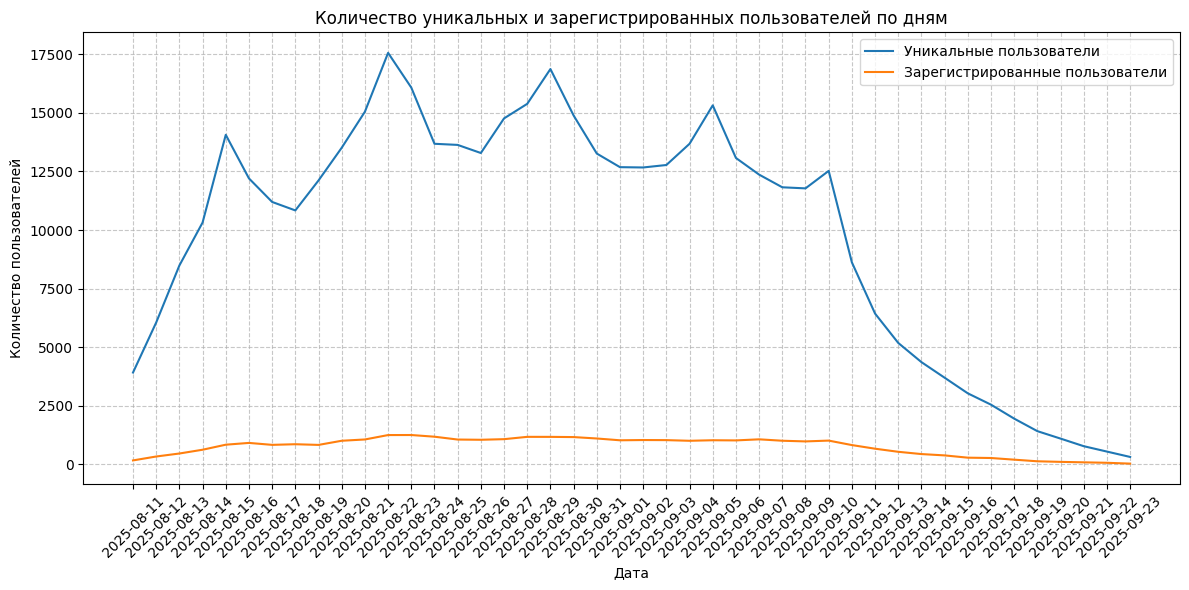

In [44]:
# Строим график количества уникальных пользователей по дням и зарегистрированных пользователей
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(daily_users['session_date'], daily_users['unique_users'], label='Уникальные пользователи')
plt.plot(daily_registered_users['session_date'], daily_registered_users['registered_users'], label='Зарегистрированные пользователи')
plt.title('Количество уникальных и зарегистрированных пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=45)
plt.legend()
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

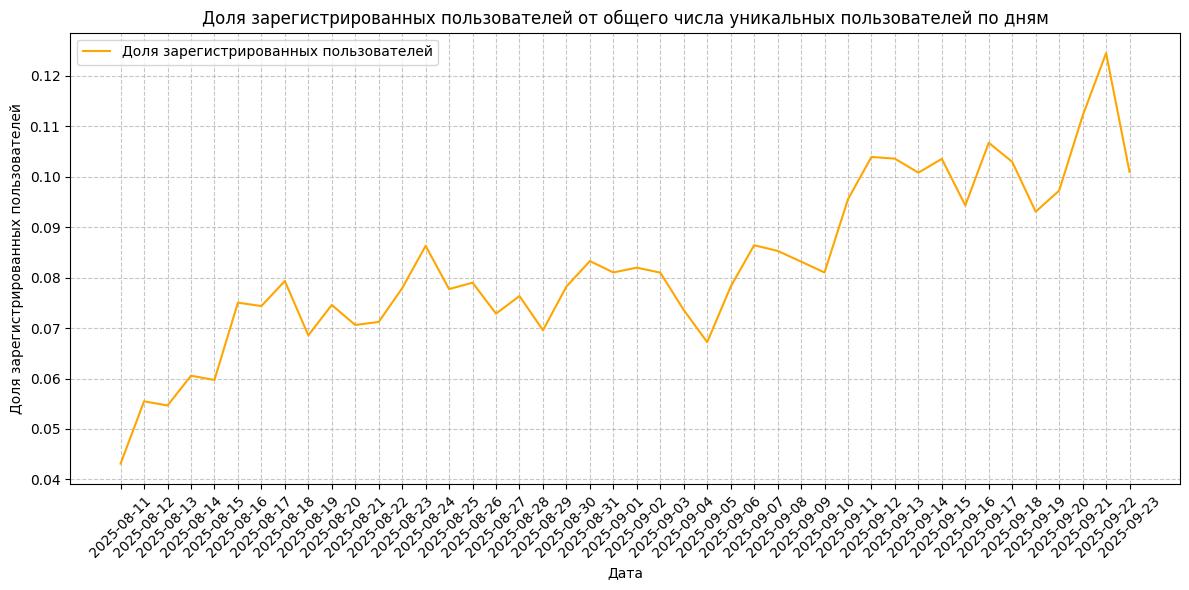

In [45]:
# Строим график доли зарегистрированных пользователей от общего числа уникальных пользователей
plt.figure(figsize=(12, 6))
plt.plot(daily_users['session_date'], daily_users['registered_users_share'], label='Доля зарегистрированных пользователей', color='orange')
plt.title('Доля зарегистрированных пользователей от общего числа уникальных пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Доля зарегистрированных пользователей')
plt.xticks(rotation=45)
plt.legend()
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### 1.4. Анализ числа просмотренных страниц
Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы на то, что он зарегистрируется и оплатит подписку.

In [46]:
# Находим количество сессий для каждого количесвта просмотренных страниц
sessions_page_count = sessions_history.groupby('page_counter')['session_id'].count().reset_index()
# Переименовываем столбцы для удобства
sessions_page_count.columns = ['page_counter', 'sessions_count']

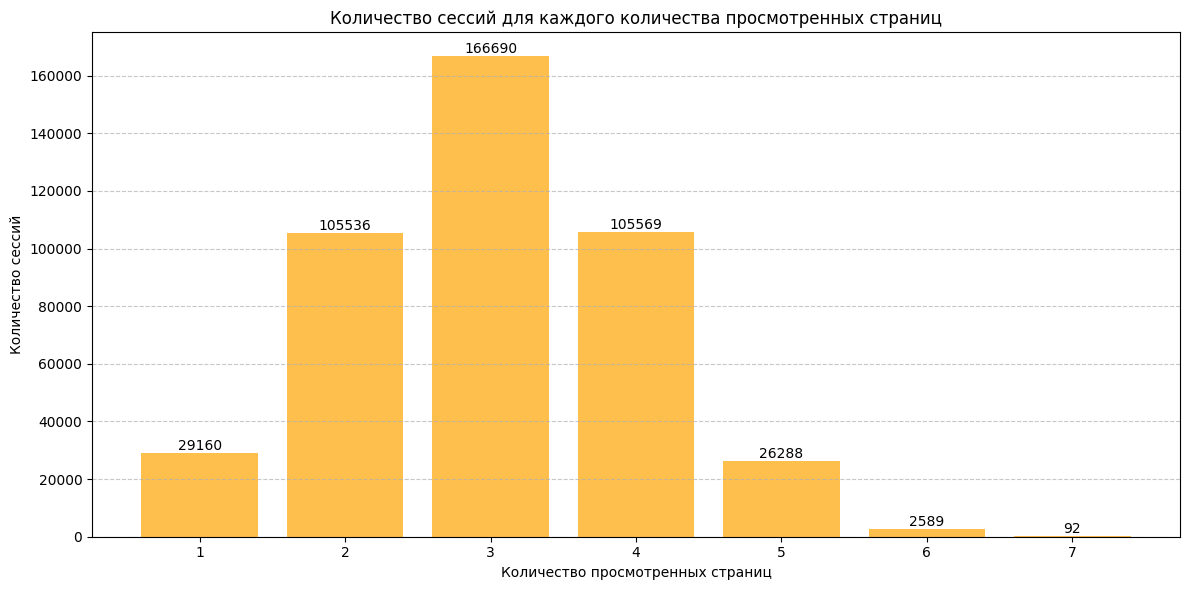

In [47]:
# Строим диаграмму количества сессий для каждого количества просмотренных страниц
plt.figure(figsize=(12, 6))
plt.bar(sessions_page_count['page_counter'], sessions_page_count['sessions_count'], color='orange', alpha=0.7)
plt.title('Количество сессий для каждого количества просмотренных страниц')
plt.xlabel('Количество просмотренных страниц')
plt.ylabel('Количество сессий')
plt.xticks(sessions_page_count['page_counter'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
# Добавляем значения над столбцами диаграммы
for i, v in enumerate(sessions_page_count['sessions_count']):
    plt.text(sessions_page_count['page_counter'].iloc[i], v, str(v), ha='center', va='bottom')
plt.show()



#### 1.5. Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.


Среднее значение доли хороших сессий: 30.75%


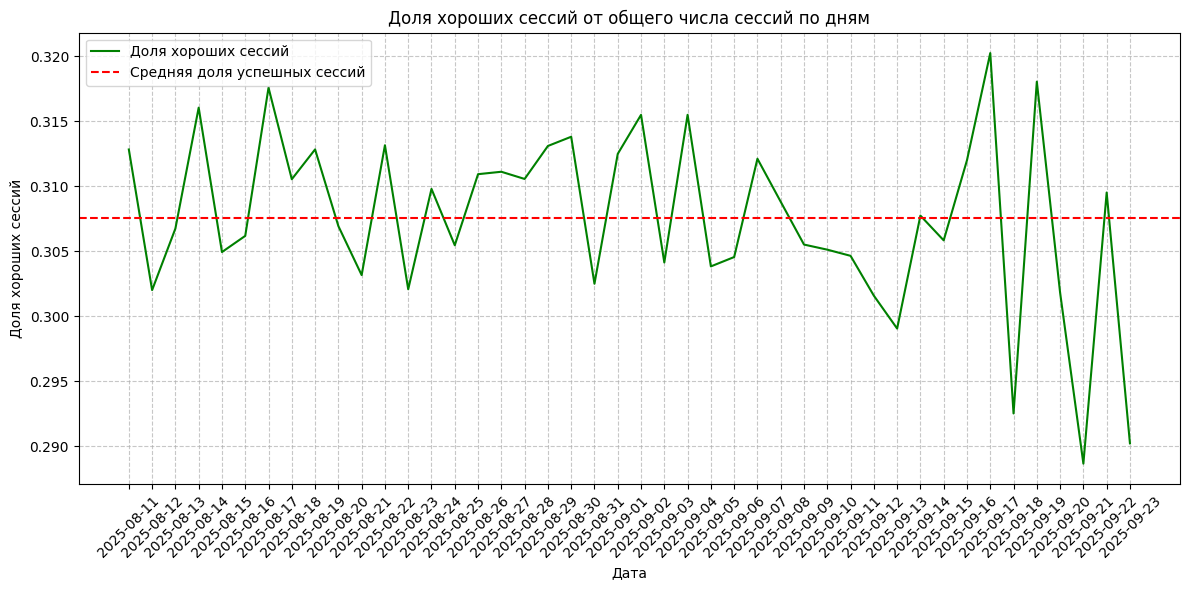

In [48]:
# Создаем новый столбец good_session в данных sessions_history, который будет равен 1, если количество просмотренных страниц больше или равно 4, иначе 0
sessions_history['good_session'] = (sessions_history['page_counter'] >= 4).astype(int)
# Группируем данные по дням и считаем количество сессий
daily_sessions = sessions_history.groupby('session_date')['session_id'].count().reset_index()
# Переименовываем столбцы для удобства
daily_sessions.columns = ['session_date', 'total_sessions']

# Группируем данные по дням и считаем количество хороших сессий
daily_good_sessions = sessions_history[sessions_history['good_session'] == 1].groupby('session_date')['session_id'].count().reset_index()
# Переименовываем столбцы для удобства
daily_good_sessions.columns = ['session_date', 'good_sessions_count']
# Объединяем данные по датам
daily_sessions = daily_sessions.merge(daily_good_sessions, on='session_date', how='left')
# Считаем долю хороших сессий от общего числа сессий
daily_sessions['good_sessions_share'] = daily_sessions['good_sessions_count'] / daily_sessions['total_sessions']
# Находим среднее значение доли хороших сессий
average_good_sessions_share = daily_sessions['good_sessions_share'].mean()
# Выводим среднее значение доли хороших сессий
print(f"Среднее значение доли хороших сессий: {average_good_sessions_share:.2%}")
# Строим график доли хороших сессий от общего числа сессий
plt.figure(figsize=(12, 6))
plt.plot(daily_sessions['session_date'], daily_sessions['good_sessions_share'], label='Доля хороших сессий', color='green')
plt.axhline(y=average_good_sessions_share, color='red', linestyle='--', label='Средняя доля успешных сессий')
plt.title('Доля хороших сессий от общего числа сессий по дням')
plt.xlabel('Дата')
plt.ylabel('Доля хороших сессий')
plt.xticks(rotation=45)
plt.legend()
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [49]:
# Выводим первые пять строк полученного датафрейма
display(daily_sessions.head())

,session_date,total_sessions,good_sessions_count,good_sessions_share
0,2025-08-11,3919,1226,0.312835
1,2025-08-12,6056,1829,0.302015
2,2025-08-13,8489,2604,0.306750
3,2025-08-14,10321,3262,0.316055
4,2025-08-15,14065,4289,0.304941


### Вывод по 1 пункту

1. **Анализ числа уникальных сессий:**
    - Наибольшее количество сессий у одного пользователя составило 10. Это говорит о том, что некоторые пользователи активно используют приложение, возвращаясь к нему многократно.

2. **Анализ числа регистраций:**
    - Доля зарегистрированных пользователей от общего числа уникальных пользователей варьируется по дням, в среднем составляя около 7.7%. Это указывает на стабильный интерес пользователей к регистрации в приложении.

3. **Анализ числа просмотренных страниц:**
    - Большинство сессий (около 38%) включают просмотр 3 страниц, что является наиболее частым сценарием использования. Сессии с просмотром 4 и более страниц составляют значительную часть, что свидетельствует о вовлечённости пользователей.

4. **Доля пользователей, просмотревших более 4 страниц:**
    - Средняя доля "хороших" сессий (с просмотром 4 и более страниц) составляет около 30.8%. Это важная метрика, показывающая, что значительная часть пользователей находит контент интересным.

В целом, исторические данные показывают стабильное использование приложения с умеренной вовлечённостью пользователей. Эти данные могут служить хорошей основой для дальнейшего анализа и проведения A/B-теста.

#### 2.1. Расчёт размера выборки


In [50]:
from statsmodels.stats.power import NormalIndPower

# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 0.8  # Мощность теста
mde = 0.03  # Минимальный детектируемый эффект

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size=mde,
    power=power,
    alpha=alpha,
    ratio=1  # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 17441


#### 2.1. Расчёт длительности A/B-теста

In [51]:
from math import ceil
# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = sessions_history.groupby('session_date')['user_id'].nunique().mean()

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(sample_size*2/ avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907.363636363636 пользователей в день составит 4 дней


### Вывод по пункту 2

1. **Расчёт размера выборки:**
    - Для проведения A/B-теста с уровнем значимости 0.05, мощностью 0.8 и минимальным детектируемым эффектом (MDE) 3% был рассчитан необходимый размер выборки. Для каждой группы требуется 17,442 пользователя.

2. **Расчёт длительности теста:**
    - Среднее количество уникальных пользователей приложения в день составляет 9,907. 
    - Для достижения необходимого размера выборки в 34,884 пользователя (17,442 на каждую группу) при текущем уровне трафика потребуется 4 дня.

Таким образом, тест можно провести за достаточно короткий срок, что позволяет минимизировать влияние внешних факторов на результаты эксперимента.

### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей


In [52]:
# Считываем и сохраняем в датафрейм `sessions_test_part` CSV-файл с данными о сессиях пользователей за период проведения A/B-теста `sessions_project_test_part.csv`.
sessions_test_part = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test_part.csv')

In [53]:
# Рассчитываем количество уникальных пользователей в каждой группе
test_part_users = sessions_test_part.groupby('test_group')['user_id'].nunique().reset_index()
# Переименовываем столбцы для удобства
test_part_users.columns = ['test_group', 'unique_users']
# Выводим данные на экран
display(test_part_users)

,test_group,unique_users
0,A,1477
1,B,1466


Количество уникальных пользователей в каждой группе A/B-теста:
  test_group  unique_users  user_share
0          A          1477   50.186884
1          B          1466   49.813116


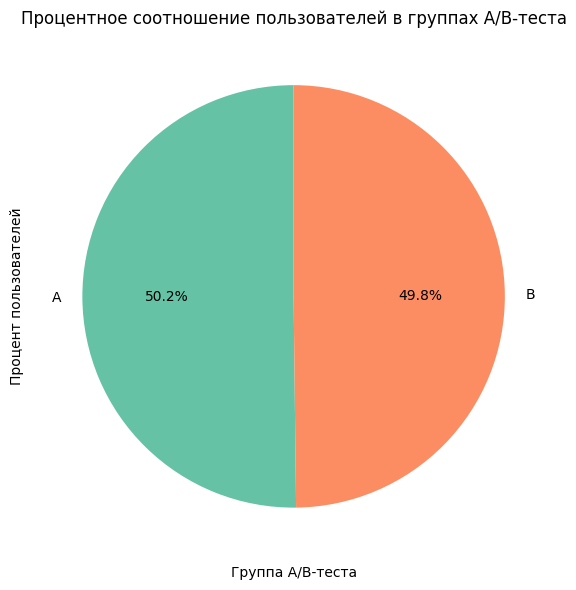

In [54]:
import seaborn as sns
# Считаем процентное соотношение пользователей в каждой группе
test_part_users['user_share'] = test_part_users['unique_users'] / test_part_users['unique_users'].sum() * 100
# Выводим информацию о количестве пользователей в каждой группе
print("Количество уникальных пользователей в каждой группе A/B-теста:")
print(test_part_users)
# Получаем цветовую палитру из Seaborn
colors = sns.color_palette("Set2")
# СТроим график процентного соотношения пользователей в каждой группе
plt.figure(figsize=(8, 6))
plt.pie(test_part_users['user_share'], labels=test_part_users['test_group'],colors=colors,startangle=90, autopct='%1.1f%%')
plt.title('Процентное соотношение пользователей в группах A/B-теста')
plt.xlabel('Группа A/B-теста')
plt.ylabel('Процент пользователей')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#### 3.2. Проверка пересечений пользователей
Помимо проверки равенства количества пользователей в группах полезно убедиться в том, что группы независимы. Для этого нужно убедиться, что никто из пользователей случайно не попал в обе группы одновременно.


In [55]:
# Проверяем, есть ли пользователи, которые попали в обе группы теста
test_a = sessions_test_part[sessions_test_part['test_group'] == 'A']
test_b = sessions_test_part[sessions_test_part['test_group'] == 'B']
intersection = list(set(test_a['user_id'])&(set(test_b['user_id'])))
# Выводим количество таких пользователей
print(f"Количество пользователей, которые попали в обе группы: {len(intersection)}")

Количество пользователей, которые попали в обе группы: 0


#### 3.3. Равномерность разделения пользователей по устройствам
Полезно также убедиться в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройства и регионам.


In [56]:
# Считаем процентное соотношение устройств в каждой группе
perc_device = sessions_test_part.groupby(['test_group', 'device'])['user_id'].nunique() / sessions_test_part.groupby('test_group')['user_id'].nunique()
perc_device = perc_device.reset_index(name='share').sort_values(by='share', ascending=False)
# Выводим информацию о процентном соотношении устройств в каждой группе
print("Процентное соотношение устройств в группах A/B-теста:")
display(perc_device)



Процентное соотношение устройств в группах A/B-теста:


,test_group,device,share
4,B,Android,0.455662
0,A,Android,0.444144
6,B,PC,0.259891
2,A,PC,0.249831
3,A,iPhone,0.200406
7,B,iPhone,0.183492
1,A,Mac,0.105619
5,B,Mac,0.100955


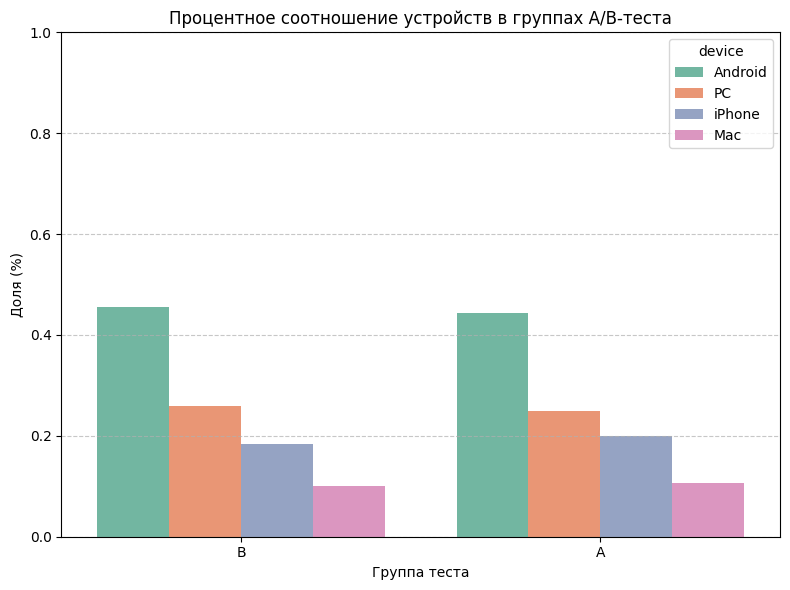

In [57]:
# Строим график процентного соотношения устройств в группах A/B-теста
plt.figure(figsize=(8, 6))
sns.barplot(data=perc_device, x='test_group', y='share', hue='device', palette='Set2')
plt.title('Процентное соотношение устройств в группах A/B-теста')
plt.ylabel('Доля (%)')
plt.xlabel('Группа теста')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.ylim(0, 1)
plt.show()

#### 3.4. Равномерность распределения пользователей по регионам
Теперь убедитесь, что пользователи равномерно распределены по регионам.

Постройте две диаграммы:

- доля каждого региона для пользователей из группы A,

- доля каждого региона для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение регионов в группах A и B. Постарайтесь использовать другой тип диаграммы, не тот, что в прошлом задании.


In [58]:
# Считаем процентное соотношение регионов в каждой группе
perc_region = sessions_test_part.groupby(['test_group', 'region'])['user_id'].nunique() / sessions_test_part.groupby('test_group')['user_id'].nunique()
perc_region = perc_region.reset_index(name='share').sort_values(by='share', ascending=False)
# Выводим информацию о процентном соотношении регионов в каждой группе
print("Процентное соотношение регионов в группах A/B-теста:")
display(perc_region)

Процентное соотношение регионов в группах A/B-теста:


,test_group,region,share
3,B,CIS,0.439973
0,A,CIS,0.436019
2,A,MENA,0.412322
5,B,MENA,0.412005
1,A,EU,0.151659
4,B,EU,0.148022


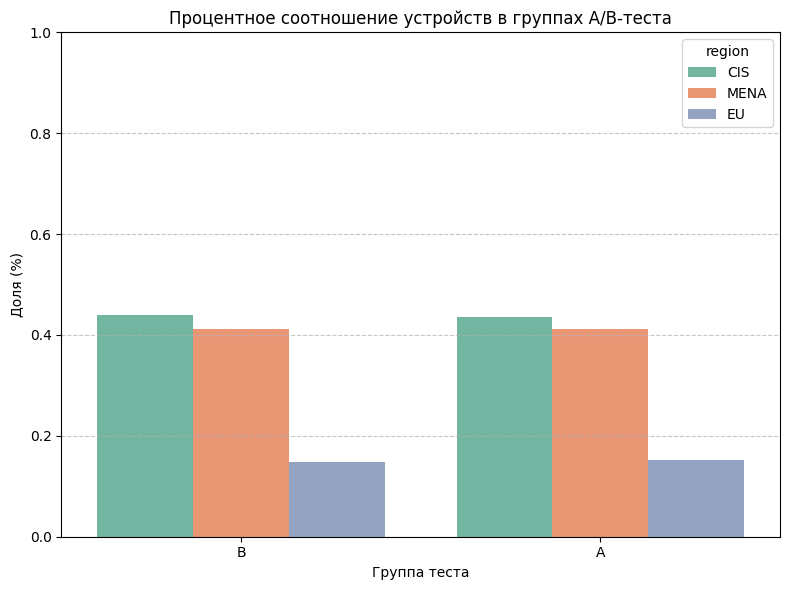

In [59]:
# Строим график процентного соотношения регионов в группах A/B-теста
plt.figure(figsize=(8, 6))
sns.barplot(data=perc_region, x='test_group', y='share', hue='region', palette='Set2')
plt.title('Процентное соотношение устройств в группах A/B-теста')
plt.ylabel('Доля (%)')
plt.xlabel('Группа теста')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.ylim(0, 1)
plt.show()

### 4. Проверка результатов A/B-теста

A/B-тест завершён, и у нас есть результаты за все дни проведения эксперимента. Необходимо убедиться в корректности теста и верно интерпретировать результаты.

#### 4.1. Получение результатов теста и подсчёт основной метрики

In [60]:
# Считываем и сохраняем в датафрейм `sessions_test` CSV-файл с данными о сессиях пользователей за период проведения A/B-теста `sessions_project_test.csv`.
sessions_test = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test.csv')

In [61]:
# Создаем новый столбец good_session в данных sessions_history, который будет равен 1, если количество просмотренных страниц больше или равно 4, иначе 0
sessions_test['good_session'] = (sessions_test['page_counter'] >= 4).astype(int)
display(sessions_test.head())

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A,0
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,0
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A,0
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B,0
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B,0


#### 4.2. Проверка корректности результатов теста


In [62]:
# Группируем данные по дням и группам и считаем количество сессий
sessions_count_test = sessions_test.groupby(['session_date','test_group'])['session_id'].nunique().reset_index()
sessions_count_test.columns = ['session_date','test_group','count']
display(sessions_count_test.head(6))

,session_date,test_group,count
0,2025-10-14,A,1502
1,2025-10-14,B,1628
2,2025-10-15,A,2235
3,2025-10-15,B,2283
4,2025-10-16,A,3280
5,2025-10-16,B,3241


In [63]:
# Импортируем необходимые библиотеки для статистического тестирования
from scipy.stats import ttest_ind
metric_a = sessions_count_test[sessions_count_test.test_group=='A']['count'] ## выборка целевой метрики для группы A
metric_b = sessions_count_test[sessions_count_test.test_group=='B']['count'] ## выборка целевой метрики для группы B

alpha = 0.05 ## на каком уровне значимости проверяем гипотезу о равенстве выборочных средних
stat_ttest, p_value_ttest = ttest_ind(
    metric_a, 
    metric_b, 
    alternative='less' ## поскольку альтернативная гипотеза о том, что выборочное среднее первой выборки(metric_a) меньше второй выборки
) ## применяем тест Стьюдента (классический T-test)

if p_value_ttest>alpha:
    print(f'p-value теста Стьюдента ={round(p_value_ttest, 2)}')
    print('Нулевая гипотеза находит подтверждение! Выборочные средние в группах A и B равны')
else:
    print(f'p-value теста Стьюдента ={round(p_value_ttest, 2)}')
    print('Нулевая гипотеза не находит подтверждения! Выборочные средние в группах A и B не равны, и в группе B больше')

p-value теста Стьюдента =0.47
Нулевая гипотеза находит подтверждение! Выборочные средние в группах A и B равны


#### 4.3. Сравнение доли успешных сессий

In [64]:
# Группируем данные по группам и считаем количество сессий
daily_sessions_test = sessions_test.groupby('test_group')['session_id'].count().reset_index()
# Переименовываем столбцы для удобства
daily_sessions_test.columns = ['test_group', 'total_sessions']

# Группируем данные по дням и считаем количество хороших сессий
daily_good_sessions_test = sessions_test[sessions_test['good_session'] == 1].groupby('test_group')['session_id'].count().reset_index()
# Переименовываем столбцы для удобства
daily_good_sessions_test.columns = ['test_group', 'good_sessions_count']
daily_sessions_test = daily_sessions_test.merge(daily_good_sessions_test, on='test_group', how='left')
# Считаем долю хороших сессий от общего числа сессий
daily_sessions_test['good_sessions_share'] = daily_sessions_test['good_sessions_count'] / daily_sessions_test['total_sessions']
display(daily_sessions_test)
row_a = daily_sessions_test['good_sessions_share'].iloc[0]
row_b = daily_sessions_test['good_sessions_share'].iloc[1]
daily_sessions_test = (row_b - row_a)*100
daily_sessions_test = daily_sessions_test.round(1)
print(f'Разница в доле успешных сессий между группами составляет {daily_sessions_test}%')

,test_group,total_sessions,good_sessions_count,good_sessions_share
0,A,49551,15248,0.307723
1,B,50454,16059,0.318290


Разница в доле успешных сессий между группами составляет 1.1%


#### 4.4. Насколько статистически значимо изменение ключевой метрики

In [65]:
from statsmodels.stats.proportion import proportions_ztest
# Проверяем предпосылку о достаточном количестве данных для применения Z-теста
n_a = sessions_test[sessions_test.test_group=='A'].shape[0] # количество наблюдений в группе A
n_b = sessions_test[sessions_test.test_group=='B'].shape[0] # количество наблюдений в группе B
m_a = sessions_test[(sessions_test.test_group=='A')&(sessions_test.good_session==1)].shape[0] # количество успехов в группе A
m_b = sessions_test[(sessions_test.test_group=='B')&(sessions_test.good_session==1)].shape[0] # количество успехов в группе B

p_a, p_b = m_a/n_a, m_b/n_b # рассчитываем доли успехов для каждой группы: A и B

print(f'n_a={n_a}, n_b={n_b}')

print(f'm_a={m_a}, m_b={m_b}')

print(f'p_a={p_a}, p_b={p_b}')

if (p_a*n_a > 10)and((1-p_a)*n_a > 10)and(p_b*n_b > 10)and((1-p_b)*n_b > 10):
    print('Предпосылка о достаточном количестве данных выполняется!')
else:
    print('Предпосылка о достаточном количестве данных НЕ выполняется!')

    alpha = 0.05 ## на каком уровне значимости проверяем гипотезу о равенстве вероятностей

stat_ztest, p_value_ztest = proportions_ztest(
    [m_a, m_b],
    [n_a, n_b],
    alternative='smaller' # так как H_1: p_a < p_b
)
p_value_ztest

if p_value_ztest > alpha:
    print(f'pvalue={p_value_ztest} > {alpha}')
    print('Нулевая гипотеза находит подтверждение!')
    print('Доля пользователей, посмотревших 4 и более страницы, в группе А и В не отличается')
else:
    print(f'pvalue={p_value_ztest} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения!')
    print('Доля пользователей, посмотревших 4 и более страницы, в группе А меньше, чем в группе В')

n_a=49551, n_b=50454
m_a=15248, m_b=16059
p_a=0.3077233557344958, p_b=0.31828992745867524
Предпосылка о достаточном количестве данных выполняется!
pvalue=0.00015747399880361237 < 0.05
Нулевая гипотеза не находит подтверждения!
Доля пользователей, посмотревших 4 и более страницы, в группе А меньше, чем в группе В


### Вывод по результатам A/B-эксперимента

1. **Характеристики эксперимента:**
    - В эксперименте участвовало 34,884 пользователя, по 17,442 в каждой группе (A и B).
    - Длительность эксперимента составила 4 дня, что соответствует рассчитанному времени на основе среднего дневного трафика приложения.

2. **Влияние нового алгоритма рекомендаций:**
    - Внедрение нового алгоритма рекомендаций привело к увеличению доли успешных сессий (с просмотром 4 и более страниц) в тестовой группе B на 1.1% по сравнению с контрольной группой A.

3. **Статистическая значимость эффекта:**
    - Значение p-value для оценки статистической значимости выявленного эффекта составило менее 0.05, что позволяет отвергнуть нулевую гипотезу и утверждать, что разница между группами статистически значима.

4. **Рекомендация:**
    - На основе полученных результатов можно сделать вывод, что внедрение нового алгоритма рекомендаций положительно влияет на ключевую метрику продукта. Рекомендуется внедрить нововведение в приложение для всех пользователей.